<a href="https://colab.research.google.com/github/ckarthik77/Local-repo/blob/main/Sign_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns
    display(Markdown(string))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/sign_mnist_train.csv')


FileNotFoundError: [Errno 2] No such file or directory: '/content/sign_mnist_train.csv'

In [ ]:
# Rename label into Label
train_df.rename(columns={'label':'Label'},inplace = True)
test_df.rename(columns={'label':'Label'},inplace = True)

# Shuffle
train_df = train_df.sample(frac = 1.0).reset_index(drop = True)
test_df = test_df.sample(frac = 1.0).reset_index(drop = True)


NameError: name 'test_df' is not defined

In [ ]:
train_df.iloc[:4,:10]

,Label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9
0,7,169,170,172,175,178,179,179,180,182
1,8,142,144,147,150,153,155,159,160,160
2,3,150,154,156,157,158,160,162,164,165
3,6,141,141,143,145,147,149,150,152,154


In [ ]:
printmd(f'### Number of images in the training set: {train_df.shape[0]}')
printmd(f'### Number of images in the test set: {test_df.shape[0]}')

d = int((train_df.shape[1] - 1)**0.5)
printmd(f'### Shape of the images: {d} x {d}')

### Number of images in the training set: 27455

### Number of images in the test set: 7172

### Shape of the images: 28 x 28

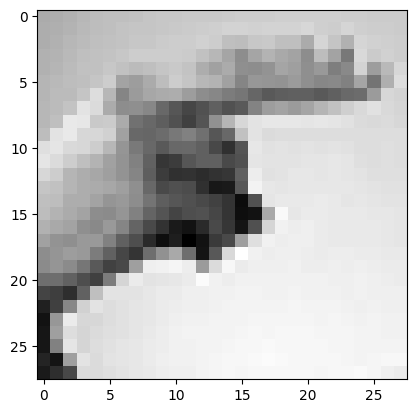

In [ ]:
def to_image(array, label = True):
    # Reshape an array into an image format
    array = np.array(array)
    start_idx = 1 if label else 0
    return array[start_idx:].reshape(28,28).astype(float)

# Display one image
img = to_image(train_df.iloc[0])
plt.imshow(img, cmap = 'gray')
plt.show()

In [ ]:
alphab = 'abcdefghijklmnopqrstuvwxyz'
mapping_letter = {}

for i,l in enumerate(alphab):
    mapping_letter[l] = i
mapping_letter = {v:k for k,v in mapping_letter.items()}

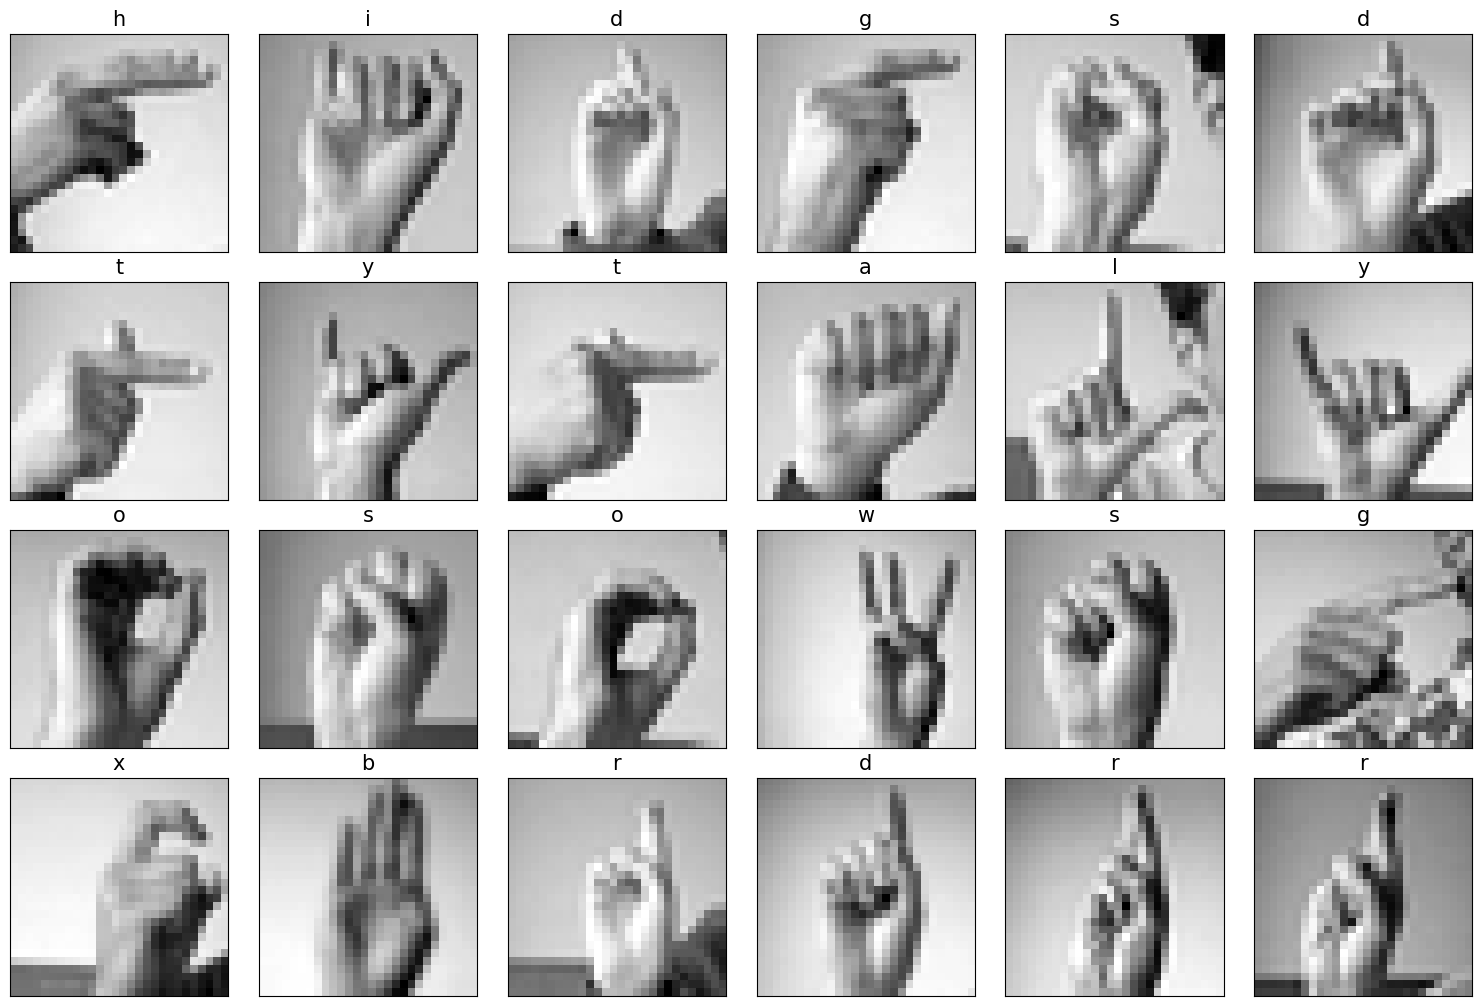

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = to_image(train_df.iloc[i])
    ax.imshow(img, cmap = 'gray')
    title = mapping_letter[train_df.Label[i]]
    ax.set_title(title, fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

<ipython-input-15-c4c853c8f7c2>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")


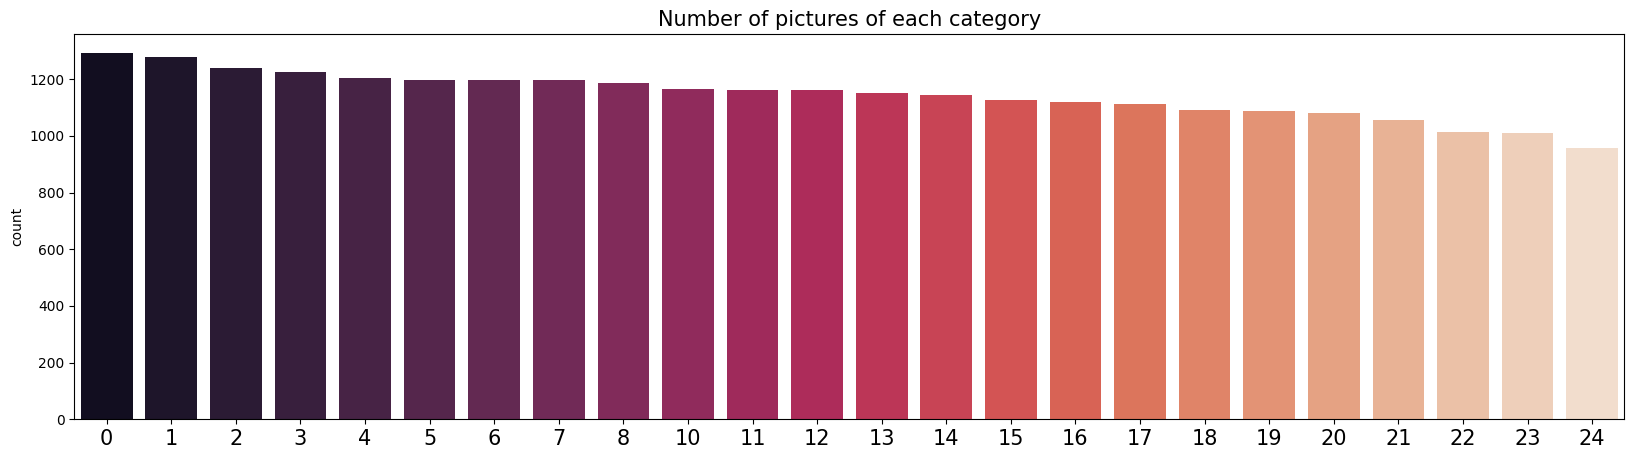

In [ ]:
vc = train_df['Label'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(fontsize = 15)
plt.show()

In [ ]:
train_df_original = train_df.copy()

# Split into training, test and validation sets
val_index = int(train_df.shape[0]*0.1)

train_df = train_df_original.iloc[val_index:]
val_df = train_df_original.iloc[:val_index]

y_train = train_df['Label']
y_val = val_df['Label']
y_test = test_df['Label']

# Reshape the traing and test set to use them with a generator
X_train = train_df.drop('Label',axis = 1).values.reshape(train_df.shape[0], 28, 28, 1)
X_val = val_df.drop('Label',axis = 1).values.reshape(val_df.shape[0], 28, 28, 1)
X_test = test_df.drop('Label',axis = 1).values.reshape(test_df.shape[0], 28, 28, 1)

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((24710, 28, 28, 1), (2745, 28, 28, 1), (7172, 28, 28, 1))

In [ ]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            rotation_range=10,
                                                            zoom_range=0.10,
                                                            width_shift_range=0.1,
                                                            height_shift_range=0.1,
                                                            shear_range=0.1,
                                                            horizontal_flip=False,
                                                            fill_mode="nearest")
X_train_flow = generator.flow(X_train, y_train, batch_size=32)
X_val_flow = generator.flow(X_val, y_val, batch_size=32)

In [ ]:
model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)),
                    MaxPool2D(2,2, padding='same'),

                    Conv2D(filters=128,  kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),

                    Conv2D(filters=512, kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),

                    Flatten(),

                    Dense(units=1024, activation="relu"),
                    Dense(units=256, activation="relu"),
                    Dropout(0.5),
                    Dense(units=25, activation="softmax")
])

model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 512)           │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 25)                  │           6,425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,994,649 (11.42 MB)

 Trainable params: 2,994,649 (11.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

history = model.fit(X_train_flow, validation_data=X_val_flow, epochs=10,callbacks=[tf.keras.callbacks.EarlyStopping( monitor='val_loss',patience=5,restore_best_weights=True), learning_rate_reduction])


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


773/773 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.2762 - loss: 2.3551 - val_accuracy: 0.8583 - val_loss: 0.4097 - learning_rate: 0.0010
Epoch 2/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.8686 - loss: 0.3909 - val_accuracy: 0.9698 - val_loss: 0.0919 - learning_rate: 0.0010
Epoch 3/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9535 - loss: 0.1423 - val_accuracy: 0.9814 - val_loss: 0.0614 - learning_rate: 0.0010
Epoch 4/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9762 - loss: 0.0770 - val_accuracy: 0.9821 - val_loss: 0.0543 - learning_rate: 0.0010
Epoch 5/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.9852 - loss: 0.0489 - val_accuracy: 0.9927 - val_loss: 0.0246 - learning_rate: 0.0010
Epoch 6/10
773/773 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.9829 - loss: 0.0595 - val_accuracy: 0.9778 - val_loss: 0.1043 - learning_rate: 0.0010
Epoch 7/10
766/773 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9877 - loss: 0.0400


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 512)           │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 25)                  │           6,425 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,983,949 (34.27 MB)

 Trainable params: 2,994,649 (11.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,989,300 (22.85 MB)

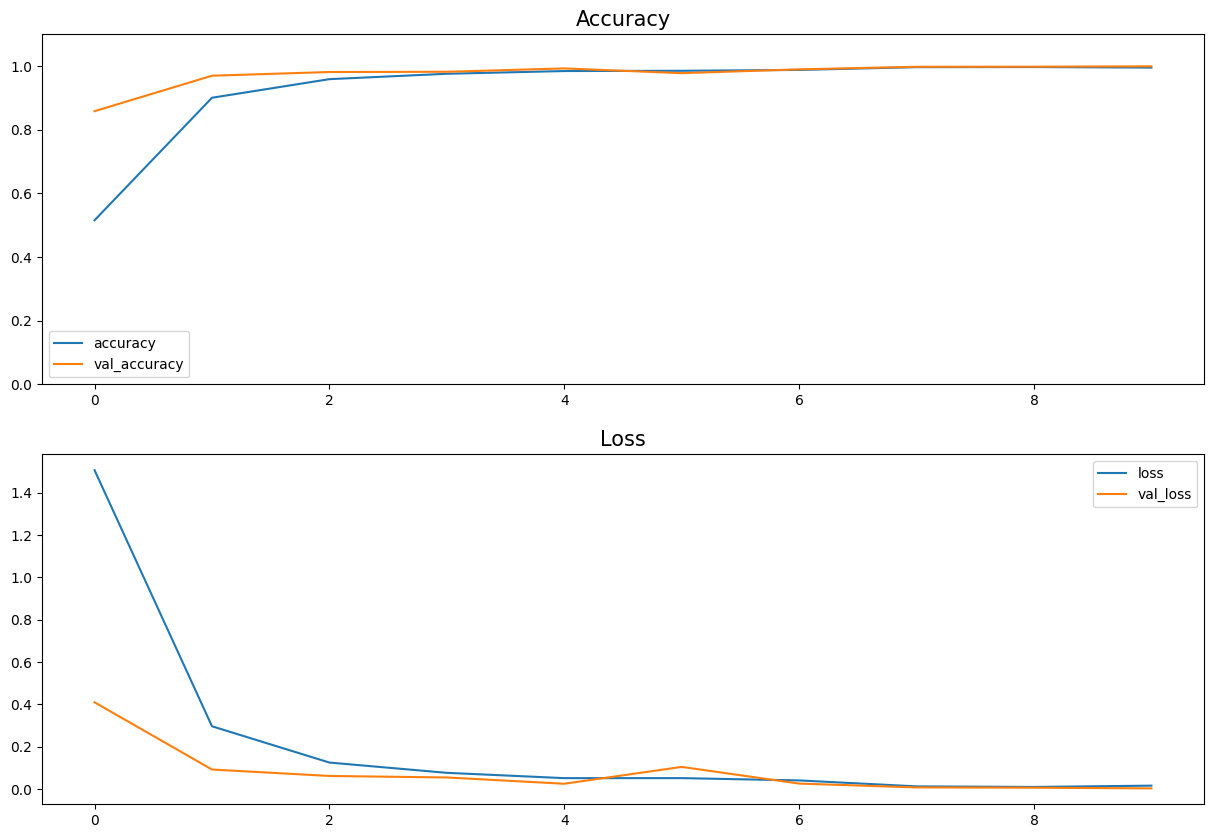

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/sign_detection1.h5')

In [ ]:
# Predict the label of the test_images
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)

# Get the accuracy score
acc = accuracy_score(y_test,pred)

# Display the results
printmd(f'## {acc*100:.2f}% accuracy on the test set')

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


## 99.92% accuracy on the test set

In [ ]:
y_test_letters = [mapping_letter[x] for x in y_test]
pred_letters = [mapping_letter[x] for x in pred]

In [ ]:
print(classification_report(y_test_letters,pred_letters))

              precision    recall  f1-score   support

           a       1.00      1.00      1.00       331
           b       1.00      1.00      1.00       432
           c       1.00      1.00      1.00       310
           d       1.00      1.00      1.00       245
           e       1.00      1.00      1.00       498
           f       1.00      1.00      1.00       247
           g       1.00      1.00      1.00       348
           h       1.00      1.00      1.00       436
           i       1.00      1.00      1.00       288
           k       1.00      1.00      1.00       331
           l       1.00      1.00      1.00       209
           m       0.99      1.00      1.00       394
           n       1.00      0.99      1.00       291
           o       1.00      1.00      1.00       246
           p       1.00      1.00      1.00       347
           q       1.00      1.00      1.00       164
           r       1.00      1.00      1.00       144
           s       1.00    

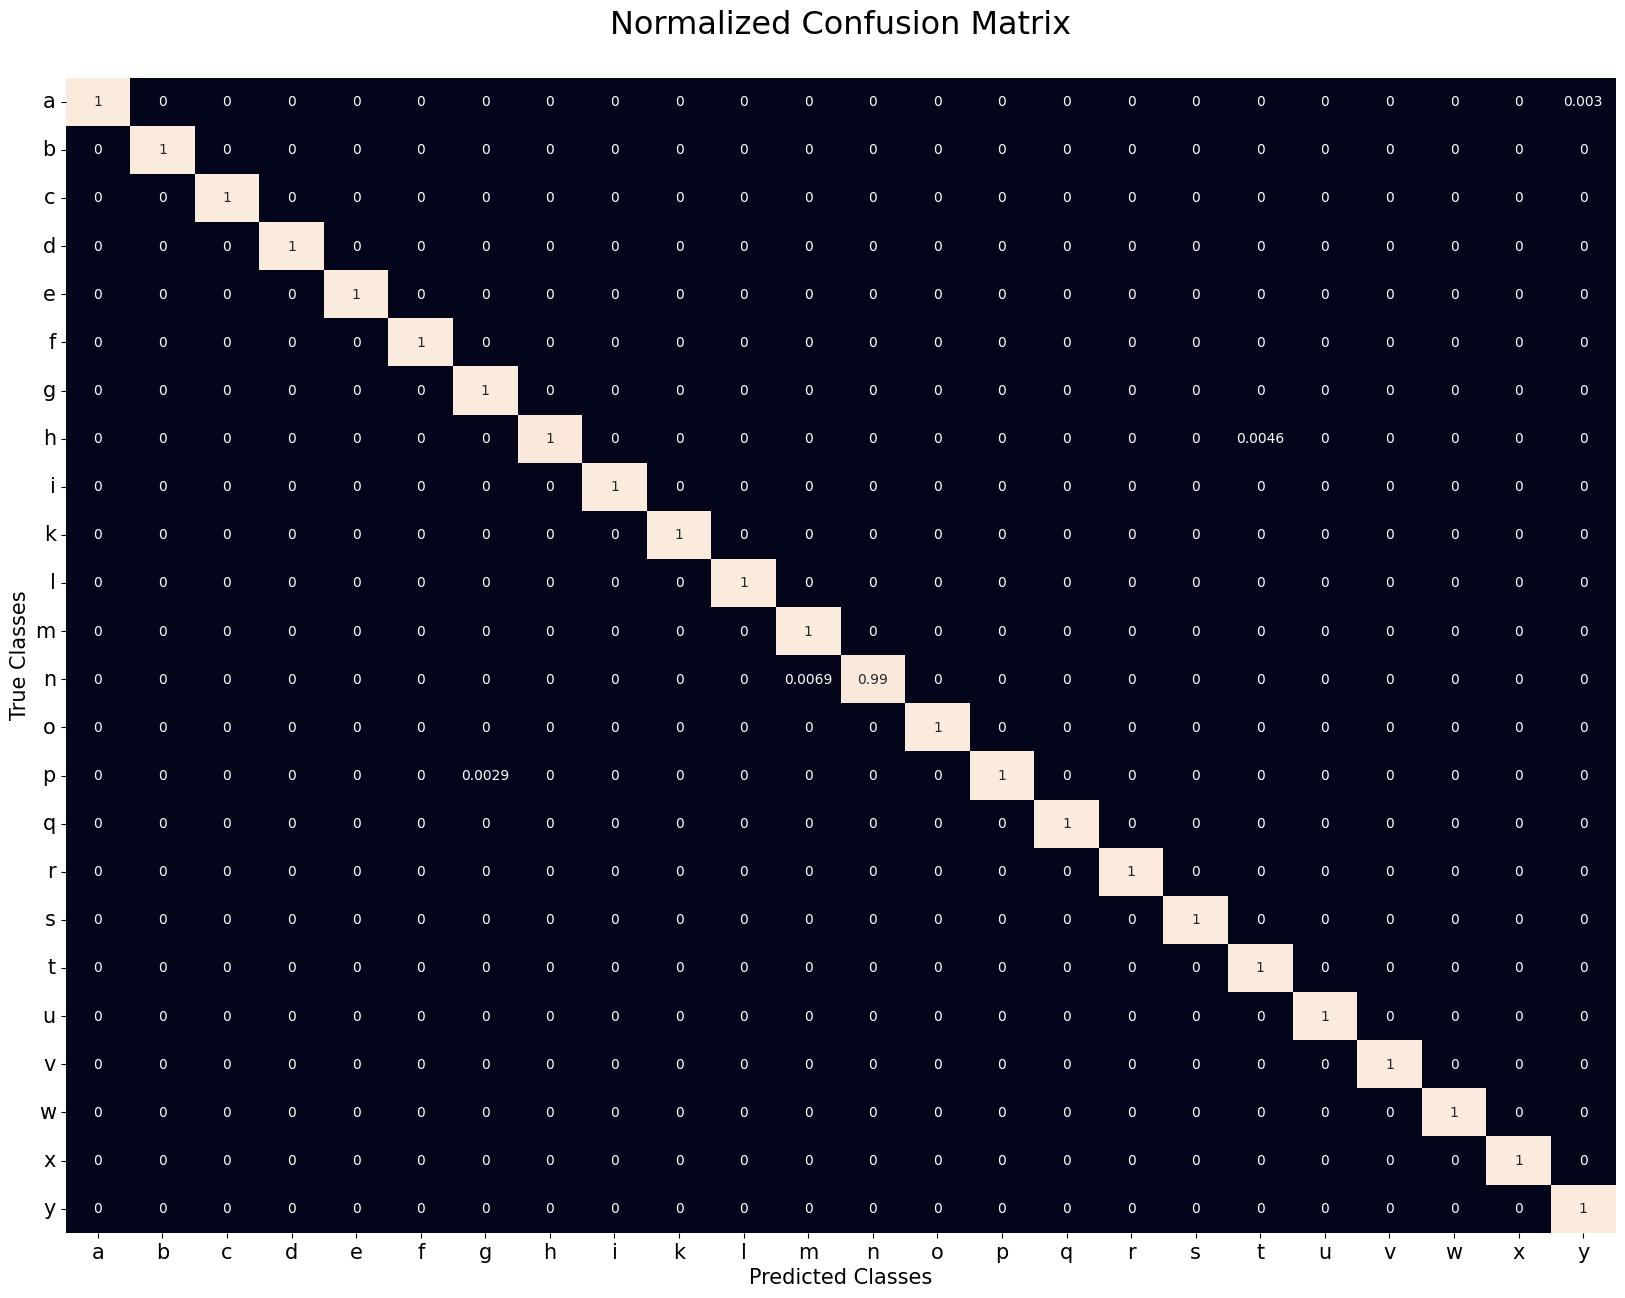

In [ ]:
cf_matrix = confusion_matrix(y_test_letters, pred_letters, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test_letters)), yticklabels = sorted(set(y_test_letters)),cbar=False)
plt.title('Normalized Confusion Matrix\n', fontsize = 23)
plt.xlabel("Predicted Classes",fontsize=15)
plt.ylabel("True Classes",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15,rotation=0)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/sign_detection1.h5')

In [ ]:
x=model.predict(X_test[3].reshape(1,28,28,1))
x=np.argmax(x,axis=1)
y=y_test[x].to_frame()
print(y['Label'])



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
6    6
Name: Label, dtype: int64


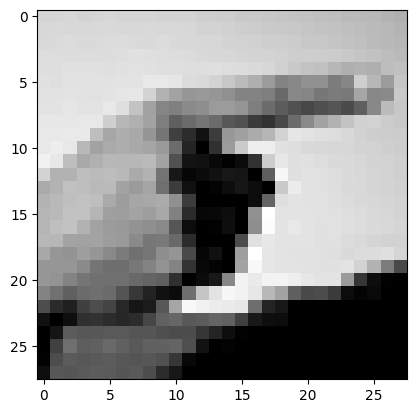

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
G


In [ ]:
plt.imshow(X_test[3].reshape(28,28),cmap='gray')
plt.show()

# Predict the value using the model
x=model.predict(X_test[3].reshape(1,28,28,1))
y_value=np.argmax(x,axis=1)[0] # Extract the predicted value

# Convert the value in the DataFrame to a string and then concatenate
print(chr(65+y_value))


Model loaded successfully from /content/drive/MyDrive/sign_detection1.h5


<IPython.core.display.Javascript object>

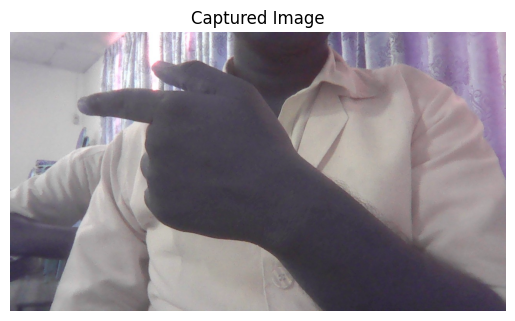

Model input shape: (None, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
Detected Text or Digit: P


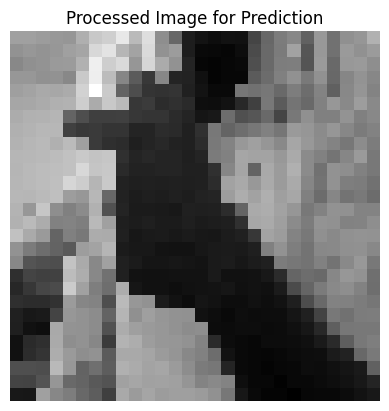

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Function to capture an image from the webcam
def take_photo(filename='photo.jpg', quality=0.9):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture Photo';
            div.appendChild(capture);
            document.body.appendChild(div);

            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({video: {width: 1280, height: 720}});
            document.body.appendChild(video);
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            await new Promise((resolve) => capture.onclick = resolve);

            context.drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            video.remove();
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    img = Image.open(BytesIO(binary)).convert("RGB")

    # Save the image
    with open(filename, 'wb') as f:
        f.write(binary)

    return np.array(img)

# Preprocess for grayscale model
def preprocess_image_for_grayscale_model(image, target_size=(28, 28)):
    if image.shape[2] == 4:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    elif image.shape[2] == 3:
        img_rgb = image
    else:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    img_resized = cv2.resize(img_gray, target_size)
    img_normalized = img_resized.astype(np.float32) / 255.0
    img_reshaped = img_normalized.reshape(1, *target_size, 1)

    return img_reshaped

# Preprocess for RGB model
def preprocess_image_for_rgb_model(image, target_size=(128, 128)):
    if image.shape[2] == 4:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    elif image.shape[2] == 3:
        img_rgb = image
    else:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    img_resized = cv2.resize(img_rgb, target_size)
    img_normalized = img_resized.astype(np.float32) / 255.0
    img_reshaped = img_normalized.reshape(1, *target_size, 3)

    return img_reshaped

# Load the model
def load_trained_model(model_path):
    try:
        model = load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

model = load_trained_model('/content/drive/MyDrive/sign_detection1.h5')  # Replace with the actual path to your saved model

# Predict text or digit
def predict_text_or_digit(model, image):
    if model is None:
        print("Model is not loaded.")
        return None

    # Check model input requirements
    model_input_shape = model.input_shape
    print(f"Model input shape: {model_input_shape}")

    # Choose preprocessing based on input shape
    if model_input_shape[-1] == 1:  # Grayscale model
        preprocessed_image = preprocess_image_for_grayscale_model(image, target_size=(28, 28))
    elif model_input_shape[-1] == 3:  # RGB model
        preprocessed_image = preprocess_image_for_rgb_model(image, target_size=(128, 128))
    else:
        raise ValueError("Unsupported model input shape")

    # Predict using the model
    predictions = model.predict(preprocessed_image)
    predicted_label = np.argmax(predictions, axis=1)[0]


    return chr(65 + predicted_label)

# Capture an image from the webcam
captured_image = take_photo()

# Optionally, display the captured image
plt.imshow(cv2.cvtColor(captured_image, cv2.COLOR_BGR2RGB))
plt.title("Captured Image")
plt.axis('off')
plt.show()

# Predict the text or digit from the captured image
predicted_text = predict_text_or_digit(model, captured_image)
print(f"Detected Text or Digit: {predicted_text}")

# Optionally, display the processed image
if model is not None:
    if model.input_shape[-1] == 3:  # RGB model
        preprocessed_image = preprocess_image_for_rgb_model(captured_image, target_size=(128, 128))
    elif model.input_shape[-1] == 1:  # Grayscale model
        preprocessed_image = preprocess_image_for_grayscale_model(captured_image, target_size=(28, 28))

    # Ensure the image is in the correct format for display
    if preprocessed_image.shape[-1] == 1:  # Grayscale
        preprocessed_image_display = preprocessed_image.reshape(preprocessed_image.shape[1], preprocessed_image.shape[2])
        plt.imshow(preprocessed_image_display, cmap='gray')
    else:  # RGB
        preprocessed_image_display = preprocessed_image.reshape(preprocessed_image.shape[1], preprocessed_image.shape[2], preprocessed_image.shape[3])
        plt.imshow(preprocessed_image_display)

    plt.title(f"Processed Image for Prediction")
    plt.axis('off')
    plt.show()

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
train_df = pd.read_csv('/content/sign_mnist_train.csv')
test_df = pd.read_csv('/content/sign_mnist_test.csv')

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7172 entries, 0 to 7171
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 43.0 MB


In [ ]:
train_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,...,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000,27455.000000
mean,12.318813,145.419377,148.500273,151.247714,153.546531,156.210891,158.411255,160.472154,162.339683,163.954799,...,141.104863,147.495611,153.325806,159.125332,161.969259,162.736696,162.906137,161.966454,161.137898,159.824731
std,7.287552,41.358555,39.942152,39.056286,38.595247,37.111165,36.125579,35.016392,33.661998,32.651607,...,63.751194,65.512894,64.427412,63.708507,63.738316,63.444008,63.509210,63.298721,63.610415,64.396846
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.500000
50%,13.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,19.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,24.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [ ]:
train_df.head(6)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
5,16,161,168,172,173,178,184,189,193,196,...,76,74,68,62,53,55,48,238,255,255


In [ ]:
train_label=train_df['label']
train_label.head()
trainset=train_df.drop(['label'],axis=1)
trainset.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


In [ ]:
X_train = trainset.values
X_train = trainset.values.reshape(-1,28,28,1)
print(X_train.shape)

(27455, 28, 28, 1)


In [ ]:
test_label=test_df['label']
X_test=test_df.drop(['label'],axis=1)
print(X_test.shape)
X_test.head()


(7172, 784)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb=LabelBinarizer()
y_train=lb.fit_transform(train_label)
y_test=lb.fit_transform(test_label)

In [ ]:
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [ ]:
X_test=X_test.values.reshape(-1,28,28,1)

In [ ]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(27455, 28, 28, 1) (27455, 24) (7172, 28, 28, 1) (7172, 24)


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 0,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

X_test=X_test/255

Text(0.5, 1.0, 'label: 13  letter: M')

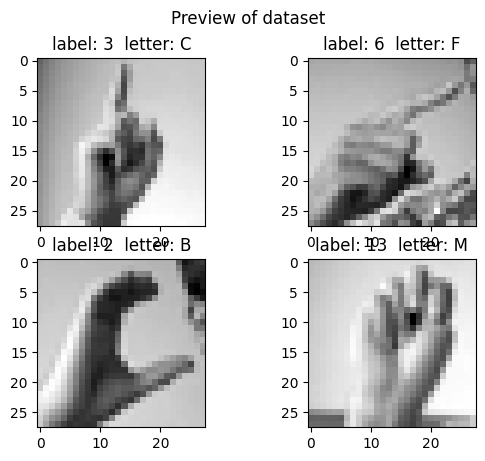

In [ ]:
fig,axe=plt.subplots(2,2)
fig.suptitle('Preview of dataset')
axe[0,0].imshow(X_train[0].reshape(28,28),cmap='gray')
axe[0,0].set_title('label: 3  letter: C')
axe[0,1].imshow(X_train[1].reshape(28,28),cmap='gray')
axe[0,1].set_title('label: 6  letter: F')
axe[1,0].imshow(X_train[2].reshape(28,28),cmap='gray')
axe[1,0].set_title('label: 2  letter: B')
axe[1,1].imshow(X_train[4].reshape(28,28),cmap='gray')
axe[1,1].set_title('label: 13  letter: M')

In [ ]:
model=Sequential()
model.add(Conv2D(128,kernel_size=(5,5),
                 strides=1,padding='same',activation='relu',input_shape=(28,28,1)))
model.add(MaxPool2D(pool_size=(3,3),strides=2,padding='same'))
model.add(Conv2D(64,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))
model.add(Conv2D(32,kernel_size=(2,2),
                strides=1,activation='relu',padding='same'))
model.add(MaxPool2D((2,2),2,padding='same'))

model.add(Flatten())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.add(Dense(units=512,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=24,activation='softmax'))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 128)         │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 14, 14, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 7, 7, 32)            │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 24)                  │          12,312 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 319,352 (1.22 MB)

 Trainable params: 319,352 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(train_datagen.flow(X_train,y_train,batch_size=200),
         epochs = 35,
          validation_data=(X_test,y_test),
          shuffle=1
         )

NameError: name 'train_datagen' is not defined

In [ ]:
model.save('sign_detection.h5')

In [ ]:
(ls,acc)=model.evaluate(x=X_test,y=y_test)

225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.0397 - loss: 3.1771


In [ ]:
print('MODEL ACCURACY = {}%'.format(acc*100))

MODEL ACCURACY = 4.043502360582352%


Model loaded successfully from /content/drive/MyDrive/sign_detection1.h5


<IPython.core.display.Javascript object>

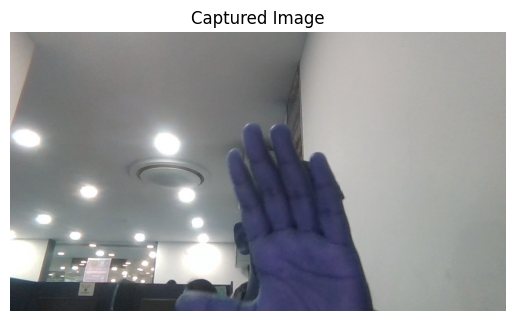

Model input shape: (None, 28, 28, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Detected Text or Digit: 3


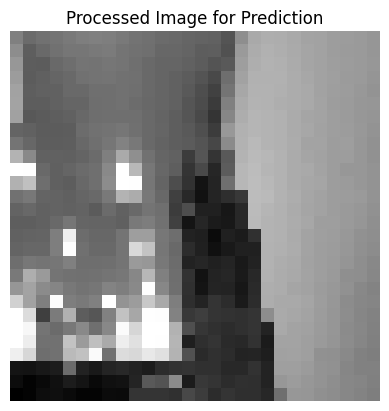

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Function to capture an image from the webcam
def take_photo(filename='photo.jpg', quality=0.9):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture Photo';
            div.appendChild(capture);
            document.body.appendChild(div);

            const video = document.createElement('video');
            const stream = await navigator.mediaDevices.getUserMedia({video: {width: 1280, height: 720}});
            document.body.appendChild(video);
            video.srcObject = stream;
            await new Promise((resolve) => video.onloadedmetadata = resolve);
            video.play();

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            const context = canvas.getContext('2d');
            await new Promise((resolve) => capture.onclick = resolve);

            context.drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            video.remove();
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    img = Image.open(BytesIO(binary)).convert("RGB")

    # Save the image
    with open(filename, 'wb') as f:
        f.write(binary)

    return np.array(img)

# Preprocess for grayscale model
def preprocess_image_for_grayscale_model(image, target_size=(28, 28)):
    if image.shape[2] == 4:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    elif image.shape[2] == 3:
        img_rgb = image
    else:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    img_resized = cv2.resize(img_gray, target_size)
    img_normalized = img_resized.astype(np.float32) / 255.0
    img_reshaped = img_normalized.reshape(1, *target_size, 1)

    return img_reshaped

# Preprocess for RGB model
def preprocess_image_for_rgb_model(image, target_size=(128, 128)):
    if image.shape[2] == 4:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
    elif image.shape[2] == 3:
        img_rgb = image
    else:
        img_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    img_resized = cv2.resize(img_rgb, target_size)
    img_normalized = img_resized.astype(np.float32) / 255.0
    img_reshaped = img_normalized.reshape(1, *target_size, 3)

    return img_reshaped

# Load the model
def load_trained_model(model_path):
    try:
        model = load_model(model_path)
        print(f"Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

model = load_trained_model('/content/drive/MyDrive/sign_detection1.h5')  # Replace with the actual path to your saved model

# Predict text or digit
def predict_text_or_digit(model, image):
    if model is None:
        print("Model is not loaded.")
        return None

    # Check model input requirements
    model_input_shape = model.input_shape
    print(f"Model input shape: {model_input_shape}")

    # Choose preprocessing based on input shape
    if model_input_shape[-1] == 1:  # Grayscale model
        preprocessed_image = preprocess_image_for_grayscale_model(image, target_size=(28, 28))
    elif model_input_shape[-1] == 3:  # RGB model
        preprocessed_image = preprocess_image_for_rgb_model(image, target_size=(128, 128))
    else:
        raise ValueError("Unsupported model input shape")

    # Predict using the model
    predictions = model.predict(preprocessed_image)
    predicted_label = np.argmax(predictions, axis=1)[0]

    # Convert prediction to readable format
    labels = ["P", "B", "N", "D", "E", "Y", "G", "H", "I", "J",
              "K", "L", "M", "O", "C", "A", "Q", "R", "S", "T",
              "U", "V", "W", "X", "F", "Z"]

    predicted_text = labels[predicted_label]

    return predicted_label

# Capture an image from the webcam
captured_image = take_photo()

# Optionally, display the captured image
plt.imshow(cv2.cvtColor(captured_image, cv2.COLOR_BGR2RGB))
plt.title("Captured Image")
plt.axis('off')
plt.show()

# Predict the text or digit from the captured image
predicted_text = predict_text_or_digit(model, captured_image)
print(f"Detected Text or Digit: {predicted_text}")

# Optionally, display the processed image
if model is not None:
    if model.input_shape[-1] == 3:  # RGB model
        preprocessed_image = preprocess_image_for_rgb_model(captured_image, target_size=(128, 128))
    elif model.input_shape[-1] == 1:  # Grayscale model
        preprocessed_image = preprocess_image_for_grayscale_model(captured_image, target_size=(28, 28))

    # Ensure the image is in the correct format for display
    if preprocessed_image.shape[-1] == 1:  # Grayscale
        preprocessed_image_display = preprocessed_image.reshape(preprocessed_image.shape[1], preprocessed_image.shape[2])
        plt.imshow(preprocessed_image_display, cmap='gray')
    else:  # RGB
        preprocessed_image_display = preprocessed_image.reshape(preprocessed_image.shape[1], preprocessed_image.shape[2], preprocessed_image.shape[3])
        plt.imshow(preprocessed_image_display)

    plt.title(f"Processed Image for Prediction")
    plt.axis('off')
    plt.show()